In [1]:
from eda_import import *

In [2]:
from scripts.sift_LR_L1_genes import load_expr, load_genes, split, generate_df_cv, sort_genes

In [3]:
dise = 'COAD'
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
n_splits = 10

# random_state = np.random.randint(0, 1e9)
random_state = 593393040
print('random_state: {0}'.format(random_state))

random_state: 593393040


In [4]:
bdf = load_expr(dise)
rsem_genes = load_genes()

In [5]:
sel_genes = [_ for _ in rsem_genes if _.split('|')[0] in ['MET', 'GNA11']]
sel_genes

['GNA11|2767', 'MET|4233']

In [6]:
Xs = bdf[sel_genes].values
Xs_scaled = StandardScaler().fit_transform(Xs)
ys = LabelEncoder().fit_transform(bdf.sstype.values)

In [7]:
Cs_dd = {}
# for k, i in enumerate([10000, 1000, 100, 10, 1, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]):
for k, i in enumerate([10000, 1, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1, 0.07, 0.05, 0.01]):
    Cs_dd['clf{0}'.format(k + 1)] = i
Cs_dd['clf0'] = 1e10

In [8]:
sorted_clf_keys = sorted(Cs_dd.keys(), key=lambda x: int(x.replace('clf', '')))

In [9]:
Cs_dd

{'clf0': 10000000000.0,
 'clf1': 10000,
 'clf10': 0.05,
 'clf11': 0.01,
 'clf2': 1,
 'clf3': 0.7,
 'clf4': 0.5,
 'clf5': 0.4,
 'clf6': 0.3,
 'clf7': 0.2,
 'clf8': 0.1,
 'clf9': 0.07}

In [10]:
clfs_dd = {}
for key, curr_c in Cs_dd.items():
    _clf = LogisticRegression(penalty='l1', C=curr_c, tol=1e-10)
    _clf.fit(Xs_scaled, ys)
    clfs_dd[key] = _clf

In [11]:
df_res = pd.DataFrame(Xs_scaled, columns=sel_genes)
df_res['sstype'] = LabelEncoder().fit_transform(bdf.sstype.values)

for key in sorted_clf_keys:
    _clf = clfs_dd[key]
    df_res[key] = _clf.predict(Xs_scaled).astype(int)    

In [12]:
df_res.head()

,GNA11|2767,MET|4233,sstype,clf0,clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9,clf10,clf11
0,0.527526,-0.031629,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0.125840,-0.570858,1,1,1,1,1,1,1,1,1,1,1,1,1
2,-0.988647,-1.163124,1,1,1,1,1,1,1,1,1,1,1,1,1
3,-0.458721,0.143292,1,1,1,1,1,1,1,1,1,1,1,1,1
4,-0.373963,3.176164,1,1,1,1,1,1,1,1,1,1,1,1,1


In [13]:
df_res[sorted_clf_keys].apply(lambda c: c.value_counts()).fillna(0)

,clf0,clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9,clf10,clf11
0,40,40,38,37,36,36,36,33,30,30,28,0.0
1,479,479,481,482,483,483,483,486,489,489,491,519.0


0,1,2,3,4,5,6,7,8,9,10,11,

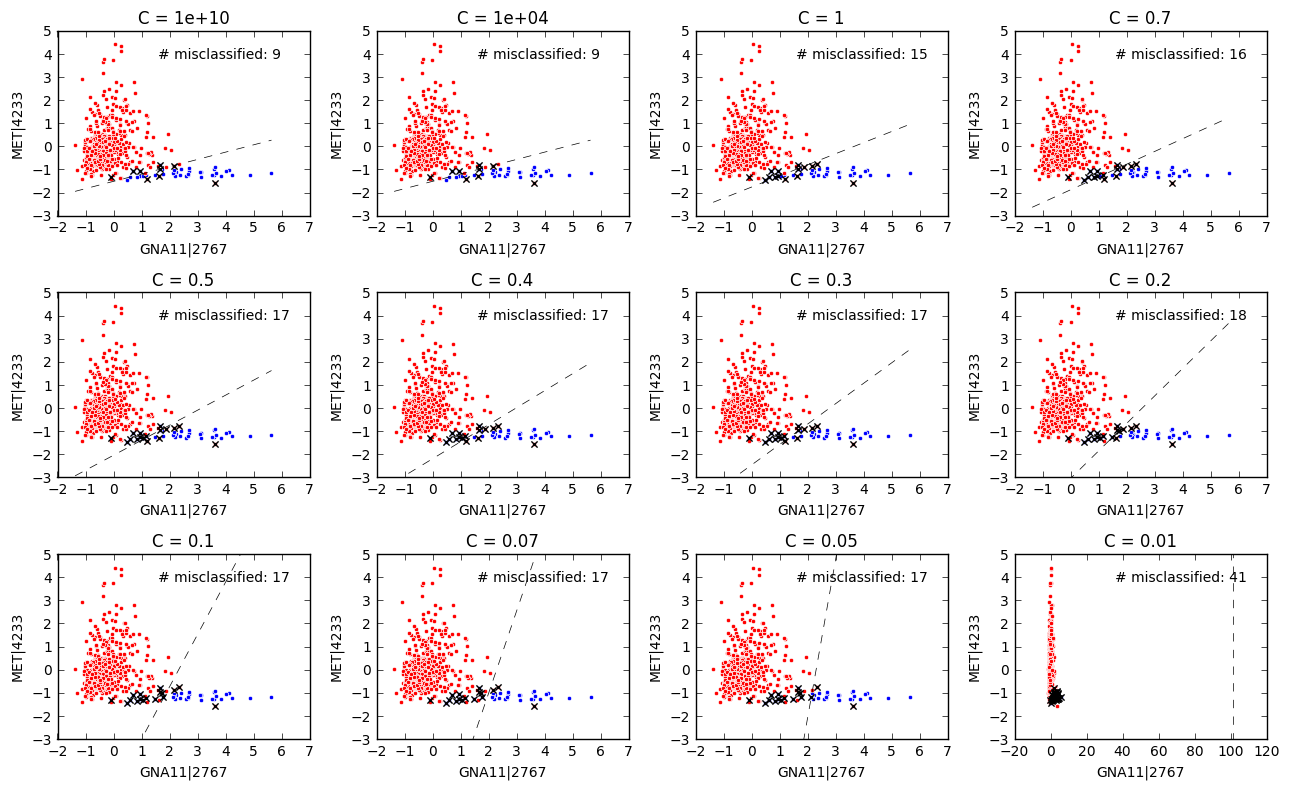

In [14]:
# fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(13, 6))
fig, axes = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(13, 8))
axes = axes.ravel()

for k, key in enumerate(sorted_clf_keys):
    print(k, end=',')
    ax = axes[k]
    
    ndf = df_res.query('sstype == 0')
    tdf = df_res.query('sstype == 1')
    xdf = df_res.query('sstype != {0}'.format(key))

    ndf.plot.scatter(ax=ax, x=sel_genes[0], y=sel_genes[1], color='blue', edgecolor='white', lw=0.5, s=10)
    tdf.plot.scatter(ax=ax, x=sel_genes[0], y=sel_genes[1], color='red',  edgecolor='white', lw=0.5, s=10)
    xdf.plot.scatter(ax=ax, x=sel_genes[0], y=sel_genes[1], color='black',  marker='x', s=20)

    _clf = clfs_dd[key]
    b0 = _clf.intercept_[0]
    b1, b2 = _clf.coef_[0]
    if b2 > 0:
        lxs = np.array([df_res[sel_genes[0]].min(), df_res[sel_genes[0]].max()])
        lys = - (b1 * lxs + b0) / b2
    else:
        lxs = [-b0 / b1, -b0 / b1]
        lys = [-10, 10]
    ax.plot(lxs, lys, '--', c='black', lw=0.5)
#     ax.text(0.1, 0.85, '${0:.2f} + {1:.2f} x_1 {2:.2f} x_2 = 0$'.format(b0, b1, b2), transform=ax.transAxes)
    ax.text(0.4, 0.85, '# misclassified: {0}'.format(xdf.shape[0]), transform=ax.transAxes)
    ax.set_title('C = {0:.0g}'.format(Cs_dd[key]))
    ax.set_ylim(-3, 5)
plt.tight_layout()

(-2, 7)

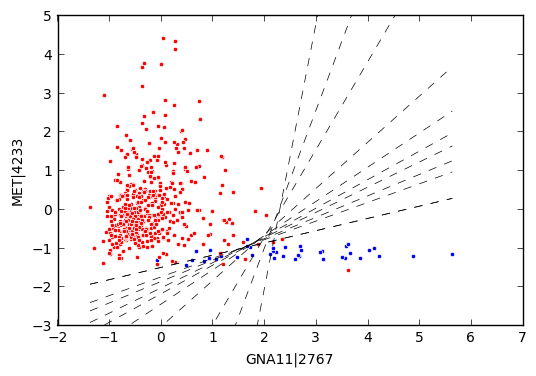

In [15]:
ax = plt.axes()

ndf = df_res.query('sstype == 0')
tdf = df_res.query('sstype == 1')

ndf.plot.scatter(ax=ax, x=sel_genes[0], y=sel_genes[1], color='blue', edgecolor='white', lw=0.5, s=10)
tdf.plot.scatter(ax=ax, x=sel_genes[0], y=sel_genes[1], color='red',  edgecolor='white', lw=0.5, s=10)

for k, key in enumerate(sorted_clf_keys):
    _clf = clfs_dd[key]
    b0 = _clf.intercept_[0]
    b1, b2 = _clf.coef_[0]
    if b2 > 0:
        lxs = np.array([df_res[sel_genes[0]].min(), df_res[sel_genes[0]].max()])
        lys = - (b1 * lxs + b0) / b2
    else:
        lxs = [-b0 / b1, -b0 / b1]
        lys = [-10, 10]
    ax.plot(lxs, lys, '--', c='black', lw=0.5)
    
ax.set_ylim(-3, 5)
ax.set_xlim(-2, 7)

### As `C` goes down, regularization strength increases, bias increases, but variance decreases. 

In [16]:
slopes = []
for key in sorted_clf_keys:
    _clf = clfs_dd[key]
    coefs = _clf.coef_[0]
    slope = - coefs[0] / max(1e-10, coefs[1])
    slopes.append((_clf.C, slope, sum([np.abs(_) for _ in coefs])))
df_clf = pd.DataFrame(slopes, columns=['C', 'slope', 'l1_loss'])

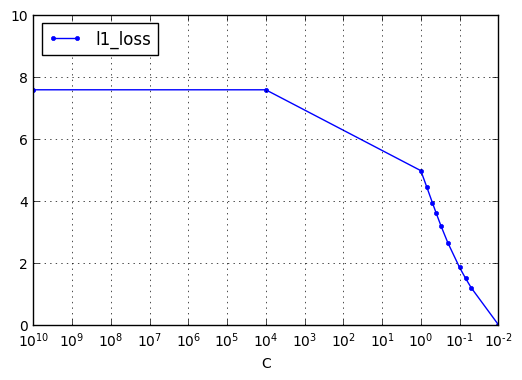

In [17]:
ax = df_clf.plot(x='C', y='l1_loss', marker='.')
ax.set_ylim(0, 10)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='upper left')
ax.grid(which='both')

Seems with C is high (e.g. > 1e3), regularization is low, there is plenty of budget to allocate.

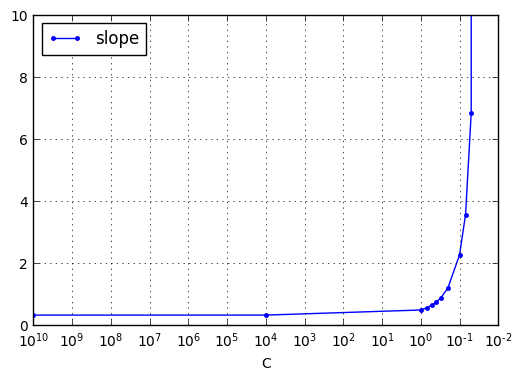

In [18]:
ax = df_clf.plot(x='C', y='slope', marker='.')
ax.set_ylim(0, 10)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='upper left')
ax.grid(which='both')